In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install matplotlib

In [1]:
import time
from datetime import timedelta
from itertools import groupby
from statistics import mean

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from keras.callbacks import Callback
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:

class TrainingPlot(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))

        if len(self.losses) > 1:
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            plt.style.use("seaborn")
            plt.figure()
            plt.plot(N, self.losses, label="train_loss")
            plt.plot(N, self.acc, label="train_acc")
            plt.plot(N, self.val_losses, label="val_loss")
            plt.plot(N, self.val_acc, label="val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

class TimeSummary(Callback):
    def on_train_begin(self, logs={}):
        self.epoch_times = []
        self.training_time = time.process_time()

    def on_train_end(self, logs={}):
        self.training_time = time.process_time() - self.training_time

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.process_time()

    def on_epoch_end(self, batch, logs={}):
        self.epoch_times.append(time.process_time() - self.epoch_time_start)

def plot_training_summary(training_summary, time_summary=None):
    if time_summary:
        print('Training time: ' + str(timedelta(seconds=time_summary.training_time)))
        print('Epoch time avg: ' + str(timedelta(seconds=mean(time_summary.epoch_times))))
    hist = sorted(training_summary.history.items(),
                  key=lambda x: (x[0].replace('val_', ''), x[0]))

    epochs = [e + 1 for e in training_summary.epoch]
    for metric, values in groupby(hist,
                                  key=lambda x: x[0].replace('val_', '')):
        if 'val_loss' in training_summary.history:
            val0, val1 = tuple(values)
            plt.plot(epochs, val0[1], epochs, val1[1], '--', marker='o')
        else:
            val0 = tuple(values)[0]
            plt.plot(epochs, val0[1], '--', marker='o')
        plt.xlabel('epoch'), plt.ylabel(val0[0])
        plt.legend(('Train set', 'Validation set'))
        plt.show()

In [3]:
class NNKeras:
    def __init__(self, url: str):
        self._url = url
        self._num_cols = 64
        self._call_back = TensorBoard(log_dir='../logs', histogram_freq=0, batch_size=32, write_graph=True,
                                      write_grads=False, write_images=False, embeddings_freq=0,
                                      embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None,
                                      update_freq='epoch')
        self._call_back_model = ModelCheckpoint('../logs/model.ckpt', monitor='val_loss', verbose=0,
                                                save_best_only=False, save_weights_only=False, mode='auto', period=1)

    def read_data(self):
        df = pd.read_csv(self._url, header=None)
        X = df.iloc[:, 1:].astype(float)
        classes = df.iloc[:, 0]
        unique_classes = pd.DataFrame(sorted([c.upper() for c in classes.unique()]))
        rows = X.shape[0]
        unique_classes['indices'] = range(1, len(unique_classes) + 1)
        y = np.zeros((rows, len(unique_classes)), np.bool)
        for i in range(rows):
            col_idx = np.where(unique_classes.loc[:, 0] == classes[i].upper())
            y[i, col_idx] = True
        return X, y, unique_classes

    def base_model(self, nodes):
        model = Sequential()

        for prev_node, node in zip(nodes[:-1], nodes[1:]):
            model.add(Dense(node, activation='relu', input_dim=prev_node))  # Add the first hidden layer

        model.add(Dense(31, activation='sigmoid'))  # Add the output layer
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def train(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=5)
        plot_losses = TrainingPlot()
        time_summary = TimeSummary()
        for num_nodes in range(2, 35):
            nodes = [64, num_nodes]
            model = self.base_model(nodes)
            callbacks = [self._call_back, time_summary, plot_losses, self._call_back_model]
            callbacks = [time_summary]
            summary = model.fit(X_train, y_train, epochs=10, verbose=0, callbacks=callbacks)
            score = model.evaluate(X_test, y_test)
            plot_training_summary(summary, time_summary)
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])
            print('Nodes:', num_nodes)

In [4]:
# nn = NNKeras("https://raw.githubusercontent.com/hardikgw/neural-network-poc/master/data/dataset/dataset.csv")
nn = NNKeras("/tf/dataset/dataset.csv")

In [5]:
X, y, unique_classes = nn.read_data()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
157/157 [==============================] - 0s 203us/step
Training time: 0:00:01.990595
Epoch time avg: 0:00:00.199041


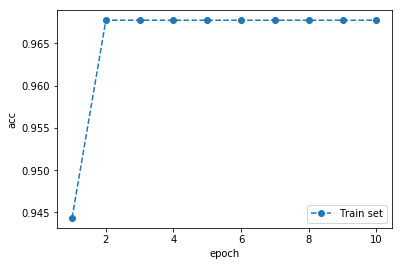

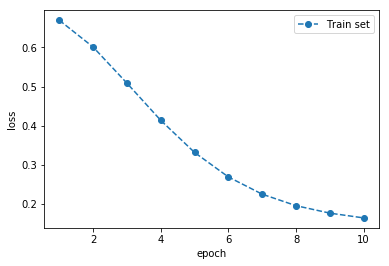

Test loss: 0.15836379501470335
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 292us/step
Training time: 0:00:02.019707
Epoch time avg: 0:00:00.201952


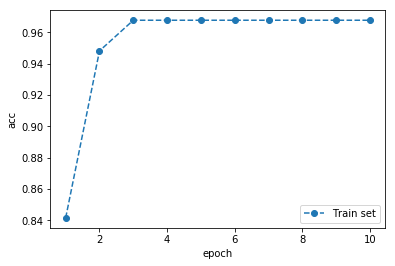

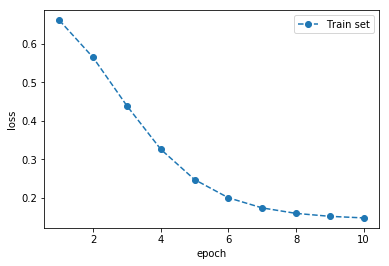

Test loss: 0.1470635062570025
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 359us/step
Training time: 0:00:02.050021
Epoch time avg: 0:00:00.204982


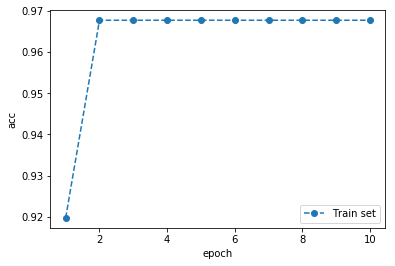

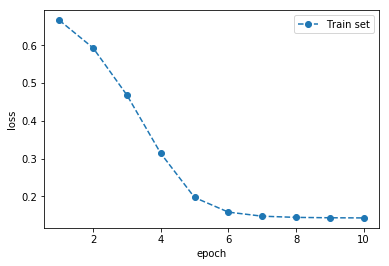

Test loss: 0.1429631356031272
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 436us/step
Training time: 0:00:02.110077
Epoch time avg: 0:00:00.210988


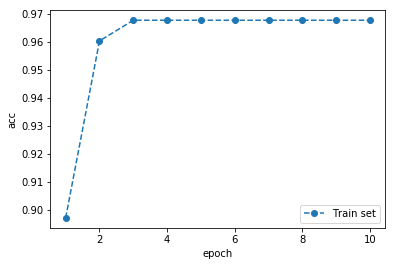

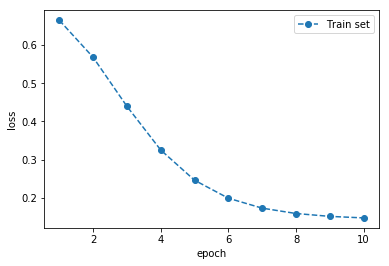

Test loss: 0.14633659448972933
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 538us/step
Training time: 0:00:02.138804
Epoch time avg: 0:00:00.213861


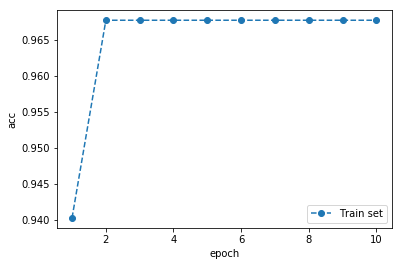

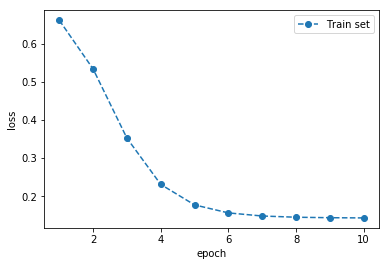

Test loss: 0.1431832566003131
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 637us/step
Training time: 0:00:02.183188
Epoch time avg: 0:00:00.218299


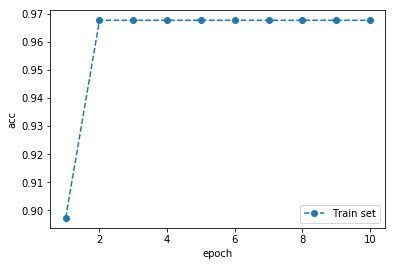

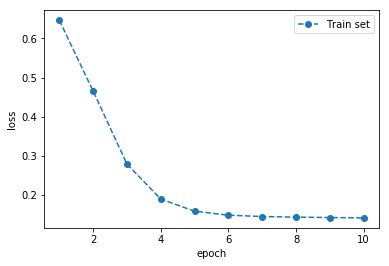

Test loss: 0.14105540865166172
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 696us/step
Training time: 0:00:02.198991
Epoch time avg: 0:00:00.219879


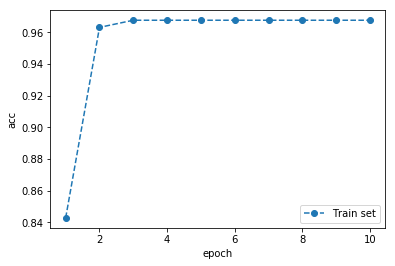

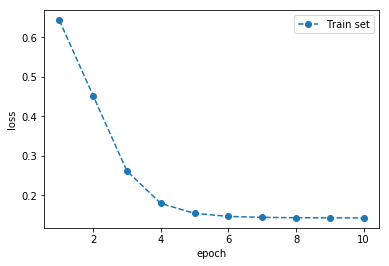

Test loss: 0.14260317261811276
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 847us/step
Training time: 0:00:02.274598
Epoch time avg: 0:00:00.227440


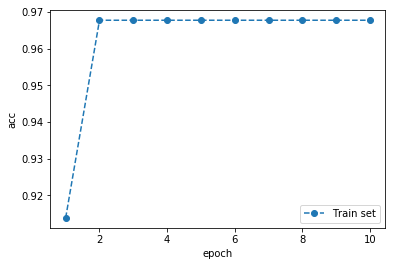

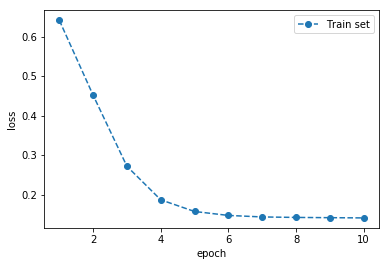

Test loss: 0.14081257562728444
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 897us/step
Training time: 0:00:02.303924
Epoch time avg: 0:00:00.230373


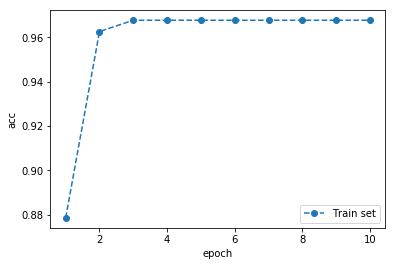

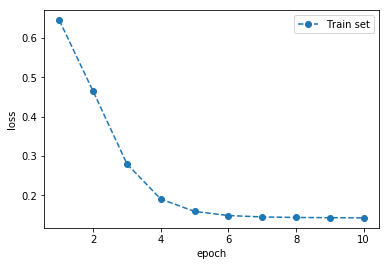

Test loss: 0.14231984459670485
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 977us/step
Training time: 0:00:02.363896
Epoch time avg: 0:00:00.236370


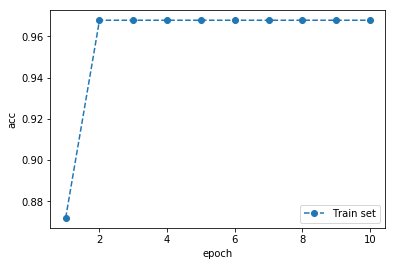

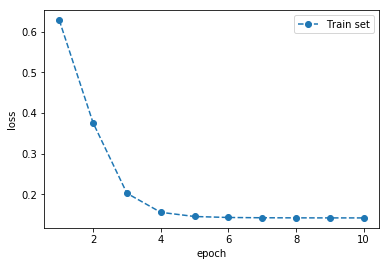

Test loss: 0.14257870870790665
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 1ms/step
Training time: 0:00:02.382536
Epoch time avg: 0:00:00.238235


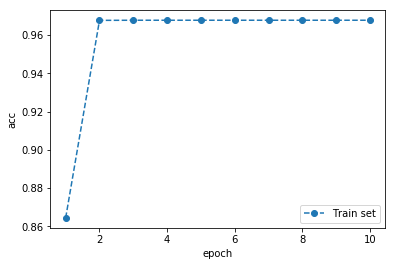

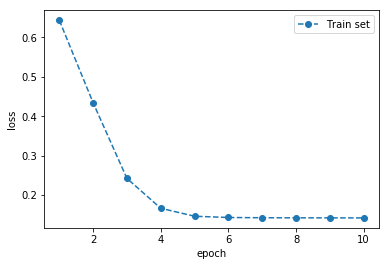

Test loss: 0.14237903049037715
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 1ms/step
Training time: 0:00:02.470258
Epoch time avg: 0:00:00.247006


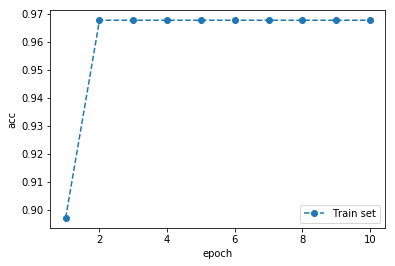

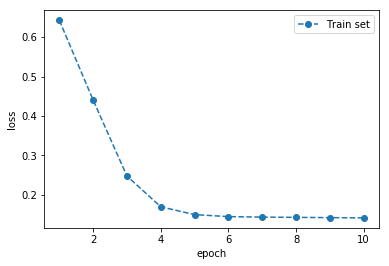

Test loss: 0.14137510120109387
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 1ms/step
Training time: 0:00:02.549074
Epoch time avg: 0:00:00.254888


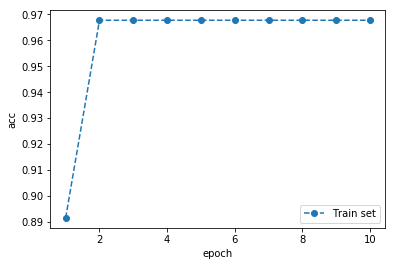

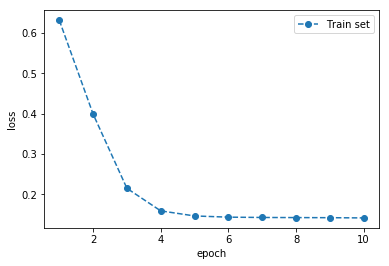

Test loss: 0.1417546962287016
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 2ms/step
Training time: 0:00:02.568718
Epoch time avg: 0:00:00.256852


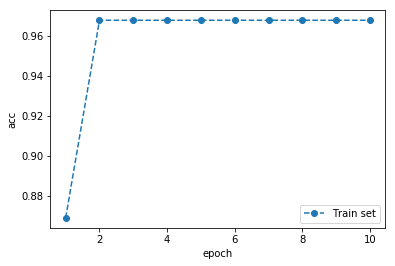

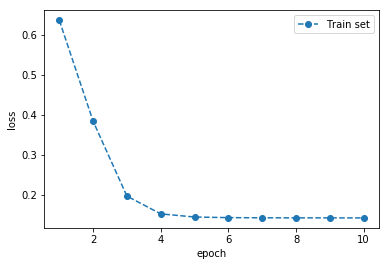

Test loss: 0.1425862984292826
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 2ms/step
Training time: 0:00:02.627794
Epoch time avg: 0:00:00.262760


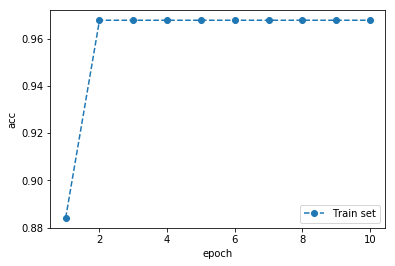

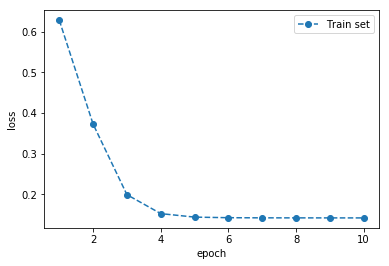

Test loss: 0.14275957425688482
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 2ms/step
Training time: 0:00:02.682866
Epoch time avg: 0:00:00.268266


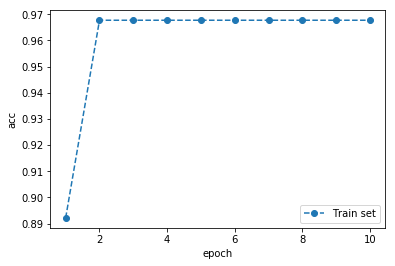

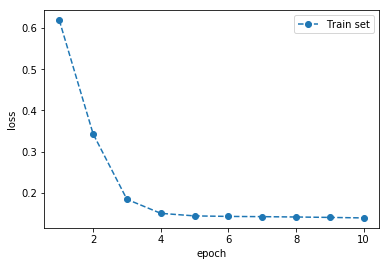

Test loss: 0.13882830179041358
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 2ms/step
Training time: 0:00:02.781163
Epoch time avg: 0:00:00.278094


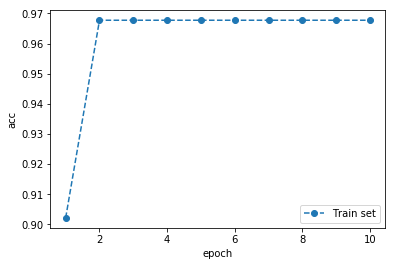

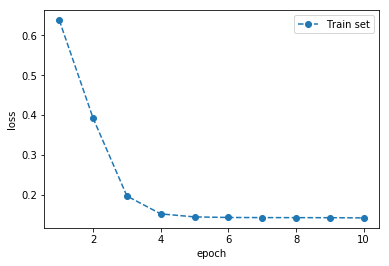

Test loss: 0.14173738544533968
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 2ms/step
Training time: 0:00:02.787437
Epoch time avg: 0:00:00.278724


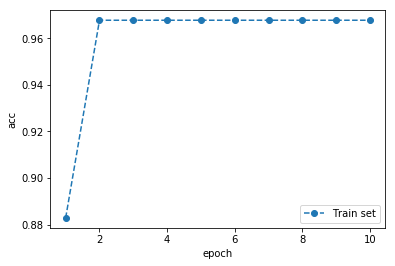

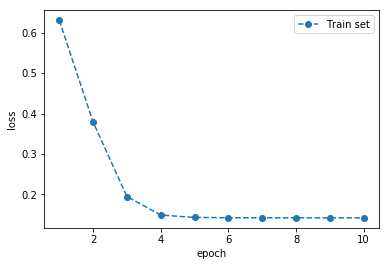

Test loss: 0.14238555216865176
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 2ms/step
Training time: 0:00:02.863143
Epoch time avg: 0:00:00.286294


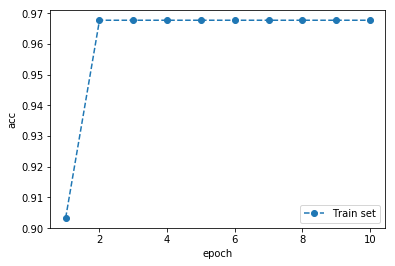

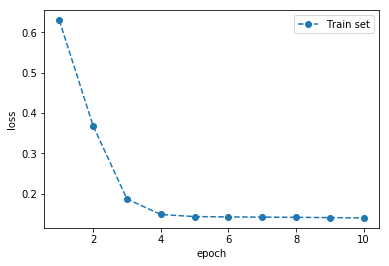

Test loss: 0.14006508383781288
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 2ms/step
Training time: 0:00:02.895641
Epoch time avg: 0:00:00.289544


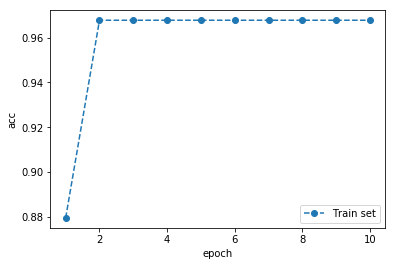

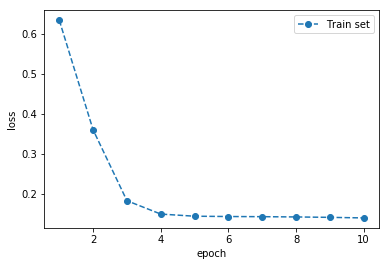

Test loss: 0.13908495635363707
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 2ms/step
Training time: 0:00:02.991407
Epoch time avg: 0:00:00.299121


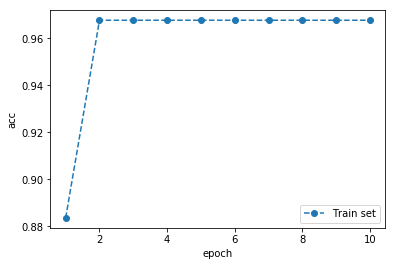

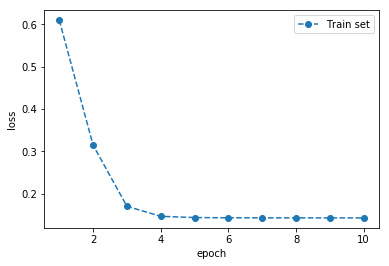

Test loss: 0.14254501234194275
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 3ms/step
Training time: 0:00:03.075800
Epoch time avg: 0:00:00.307560


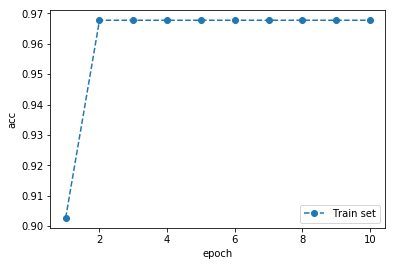

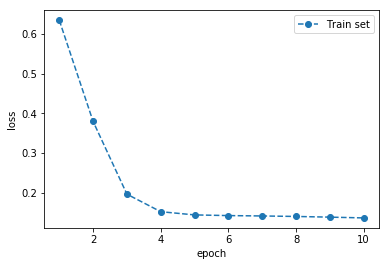

Test loss: 0.1353847729931971
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 3ms/step
Training time: 0:00:03.168070
Epoch time avg: 0:00:00.316787


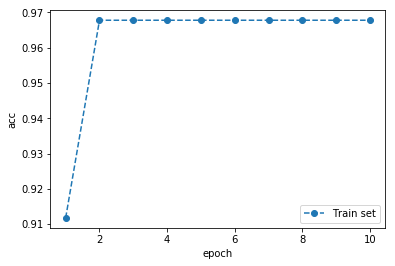

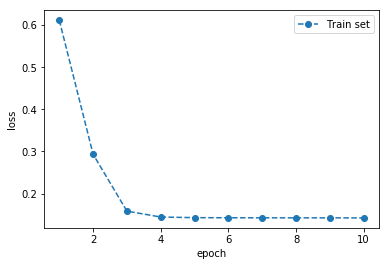

Test loss: 0.1423495520072378
Test accuracy: 0.9677418956331386
157/157 [==============================] - 0s 3ms/step
Training time: 0:00:03.198732
Epoch time avg: 0:00:00.319854


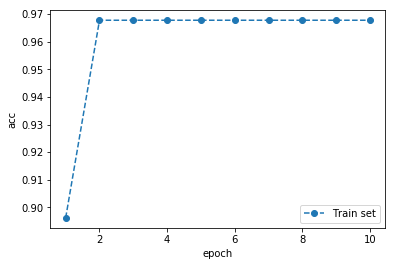

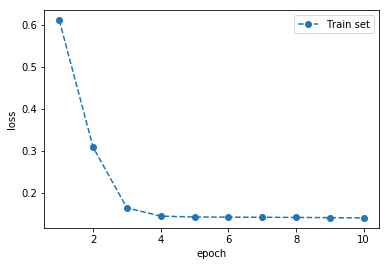

Test loss: 0.14056663480913564
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 3ms/step
Training time: 0:00:03.288403
Epoch time avg: 0:00:00.328820


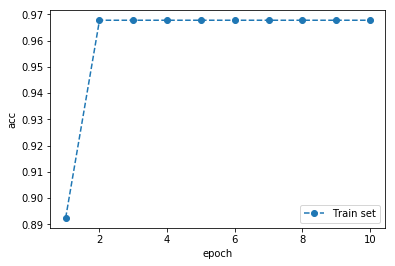

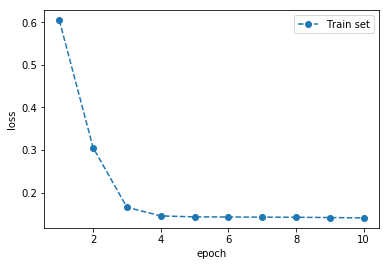

Test loss: 0.1401871008098505
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 4ms/step
Training time: 0:00:03.467715
Epoch time avg: 0:00:00.346751


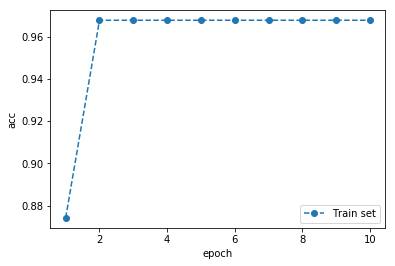

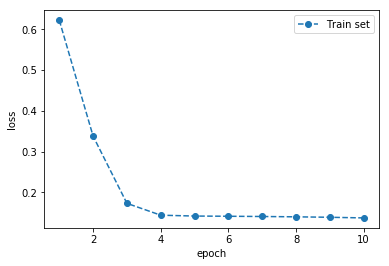

Test loss: 0.1371092449897414
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 4ms/step
Training time: 0:00:03.519753
Epoch time avg: 0:00:00.351955


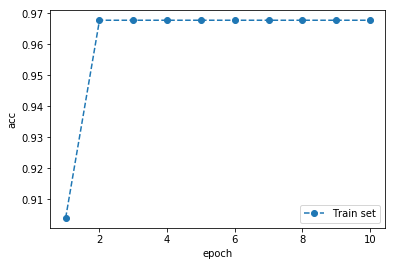

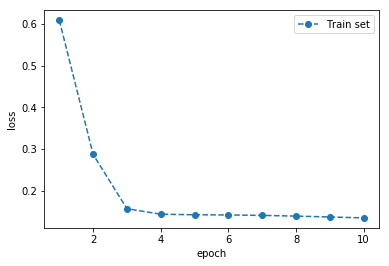

Test loss: 0.13426671722891984
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 4ms/step
Training time: 0:00:03.611383
Epoch time avg: 0:00:00.361117


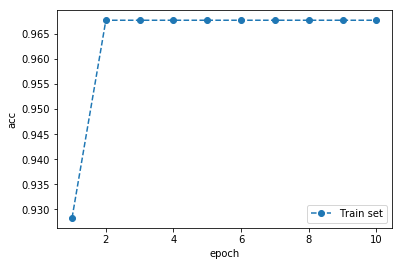

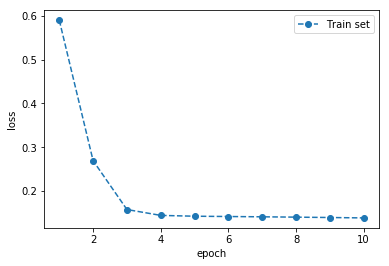

Test loss: 0.13872175184404775
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 4ms/step
Training time: 0:00:03.718671
Epoch time avg: 0:00:00.371847


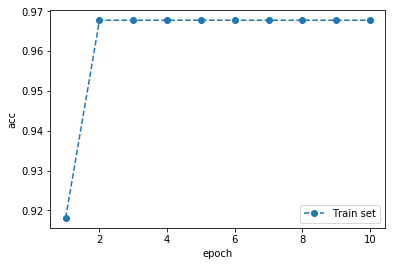

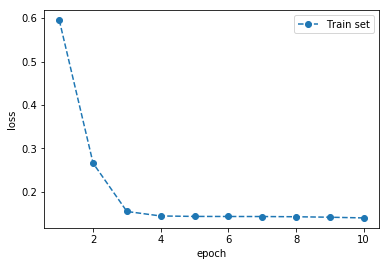

Test loss: 0.13833310886932787
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 4ms/step
Training time: 0:00:03.729978
Epoch time avg: 0:00:00.372978


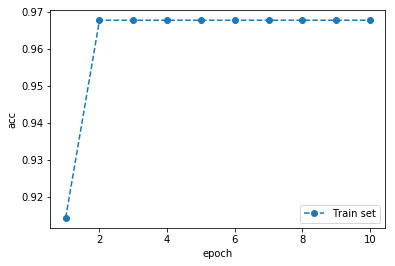

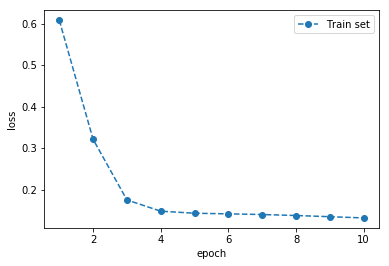

Test loss: 0.1310015788693337
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 4ms/step
Training time: 0:00:03.832184
Epoch time avg: 0:00:00.383198


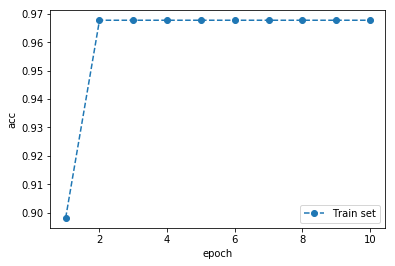

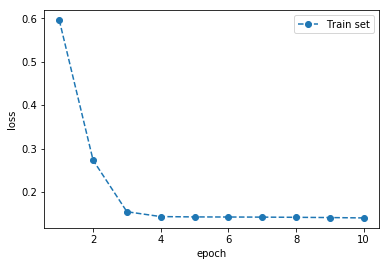

Test loss: 0.14016985969178997
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 5ms/step
Training time: 0:00:03.864642
Epoch time avg: 0:00:00.386444


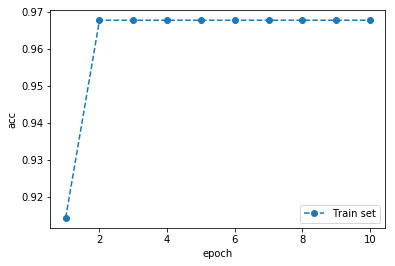

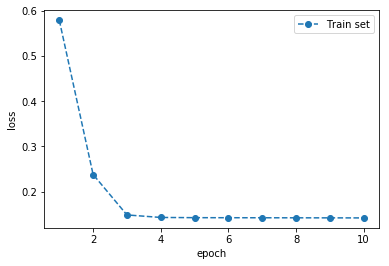

Test loss: 0.14232407519771795
Test accuracy: 0.9677418956331386
157/157 [==============================] - 1s 5ms/step
Training time: 0:00:03.955014
Epoch time avg: 0:00:00.395481


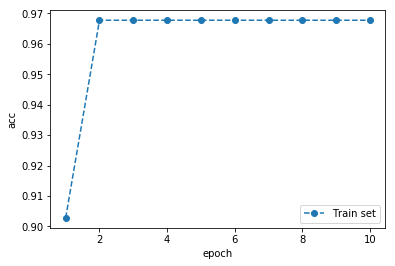

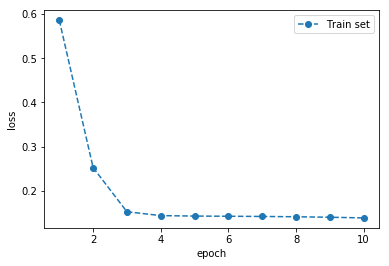

Test loss: 0.13792896356172624
Test accuracy: 0.9677418956331386


In [6]:
nn.train(X, y)